# Vocabulary Size를 변경해서 시도

## 1. 모든단어 사용

In [1]:
#모듈 import

from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### 1) 데이터 확인하기

In [2]:
#훈련 데이터, 테스트 데이터 로드

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


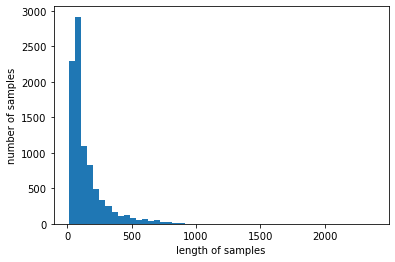

In [3]:
# 데이터 분포 확인

print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

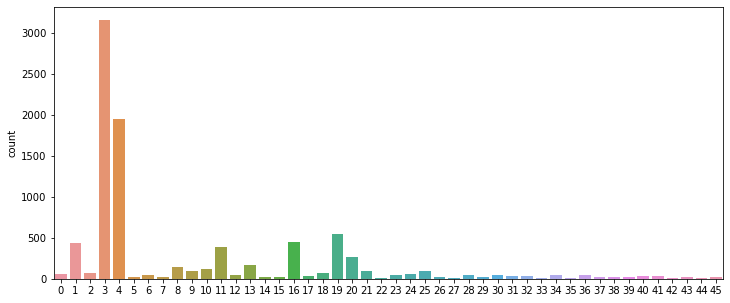

In [4]:
# 클래스 분포 확인

fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)

In [5]:
# 클래스별 갯수 확인

unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


### 2) 원본 뉴스 데이터로 복원

In [6]:
# Vocabulary 생성

word_index = reuters.get_word_index(path="reuters_word_index.json")

# 데이터 매핑 확인

word_index['the']

1

In [7]:
# index_to_word 생성

index_to_word = {index + 3 : word for word, index in word_index.items()}

# 데이터 확인

print(index_to_word[4])

the


In [8]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.

for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [9]:
# 훈련용 뉴스 기사 텍스트 복원
# train data

decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

x_train[:5]

['<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 "<sos> generale de banque sa lt genb br and lt heller overseas corp of chicago have each taken 50 pct stakes in factoring company sa belgo factors generale de banque said in a statement it gave no financial details of the transaction sa belgo factors' turnover in 1986 was 17 5 billion belgian francs reuter 3",
 '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect th

In [10]:
# test data

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

x_test[:5]

['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3',
 "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration sra chairman arsenio yulo said yu

### 3) 벡터화 하기

In [11]:
# DTM 생성

dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


In [12]:
# TF-IDF Matrix 생성

tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 26506)


### 4) 나이브 베이즈 분류기

In [13]:
# 나이브 베이즈 분류기 사용

mod = MultinomialNB()
mod.fit(tfidfv, y_train)

MultinomialNB()

In [14]:
# test data 처리

x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.5997328584149599


In [15]:
# 샘플 출력

#원문 출력
print(x_test[3])

#샘플 레이블
print(y_test[3])

<sos> graham mccormick oil and gas partnership said it completed the sale of interests in two major oil and gas fields to lt energy assets international corp for 21 mln dlrs the company said it sold about one half of its 50 pct interest in the oak hill and north rucias fields its two largest producing properties it said it used about 20 mln dlrs of the proceeds to prepay principal on its senior secured notes semi annual principal payments on the remaining 40 mln dlrs of notes have been satisfied until december 1988 as a result it said the company said the note agreements were amended to reflect an easing of some financial covenants and an increase of interest to 13 5 pct from 13 0 pct until december 1990 it said the noteholders exercise price for 1 125 000 warrants was also reduced to 50 cts from 1 50 dlrs the company said energy assets agreed to share the costs of increasing production at the oak hill field reuter 3
4


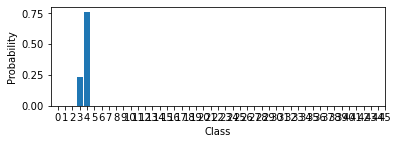

In [16]:
#그래프 시각화
plt.subplot(211)
plt.rcParams["figure.figsize"] = (10,10)
plt.bar(mod.classes_, mod.predict_proba(tfidfv_test[3])[0])
plt.xlim(-1, 21)
plt.xticks(mod.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

In [17]:
# 예측 정답 확인

mod.predict(tfidfv_test[3])

array([4])

### 5) F1-Score, Confusion Matrix

In [18]:
# 평가 score

print(classification_report(y_test, mod.predict(tfidfv_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.79      0.21      0.33       105
           2       0.00      0.00      0.00        20
           3       0.72      0.92      0.81       813
           4       0.45      0.96      0.61       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        30
          11       0.80      0.29      0.42        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.75      0.18      0.29        99
          17       0.00    

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

macro: 단순평균   
weighted: 각 클래스에 속하는 표본의 개수로 가중평균   
accuracy: 정확도. 전체 학습 데이터의 개수에서 클래스를 정확하게 맞춘 개수의 비율.

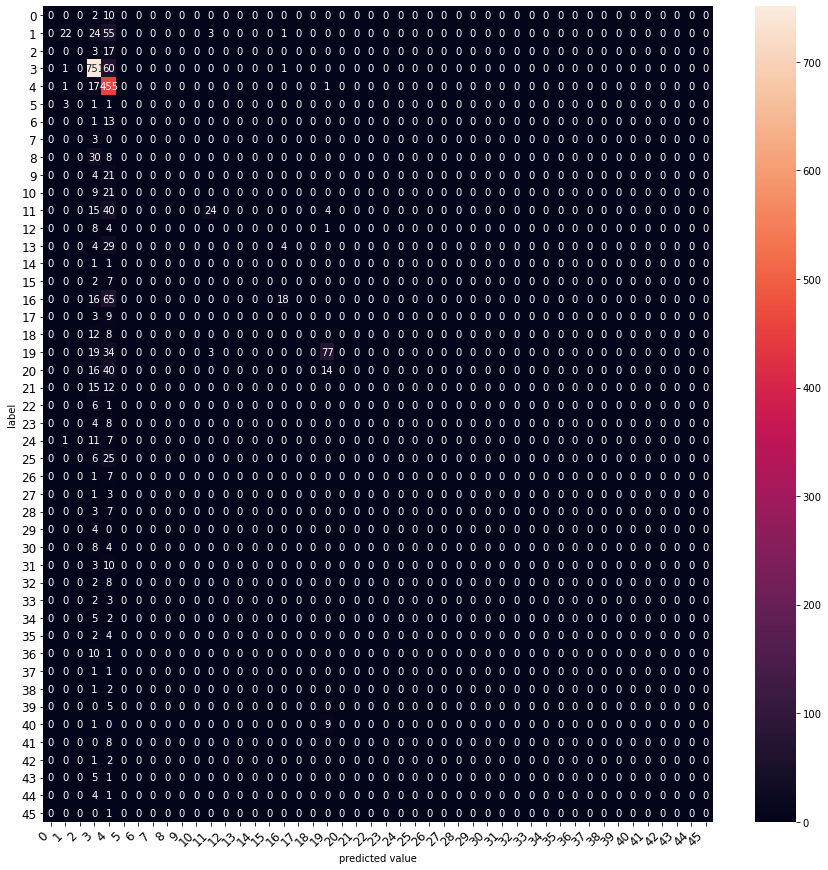

In [19]:
# confusion matrix 시각화

def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
  df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
  fig = plt.figure(figsize=(15,15))
  heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
  plt.ylabel('label')
  plt.xlabel('predicted value')

graph_confusion_matrix(mod, tfidfv_test, y_test)

### 6) 다양한 모델 시도

In [20]:
# Complement Naive Bayes Classifier(CNB)

cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [21]:
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7649154051647373


In [22]:
# Logistic Regression

lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10000)

In [23]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.813446126447017


In [24]:
# LinearSVC

lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1000, dual=False, max_iter=500, penalty='l1')

In [25]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7773820124666073


In [26]:
# Decision Tree

tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [27]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6211041852181657


In [28]:
# Random Forest

forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [29]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6544968833481746


In [30]:
# Gradient Boosting Tree

grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [31]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7702582368655387


In [32]:
# Soft Voting

voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft')

In [33]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8187889581478184


#### 모델별 accuracy

F1-score : 0.60   
Complement Naive Bayes(CNB): 0.7649154051647373  
Logistic Regression : 0.813446126447017  
LinearSVC : 0.7773820124666073  
Decision Tree : 0.6211041852181657  
Random Forest : 0.6544968833481746
Gradient Boosting Tree : 0.7702582368655387
Soft Voting : 0.8187889581478184  
    
Soft Voting이 81.88%로 가장 높게 나왔다.

## 2. 빈도수 상위 5,000개의 단어만 사용

### 1) 데이터 확인하기

In [34]:
#훈련 데이터, 테스트 데이터 로드

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


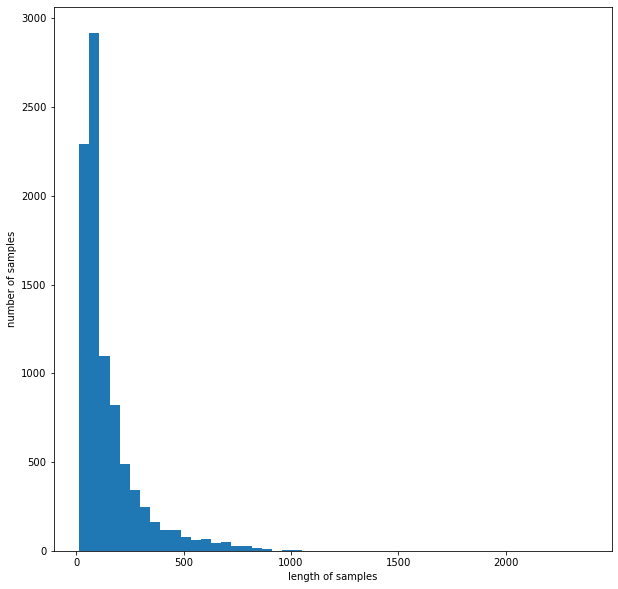

In [35]:
# 데이터 분포 확인

print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

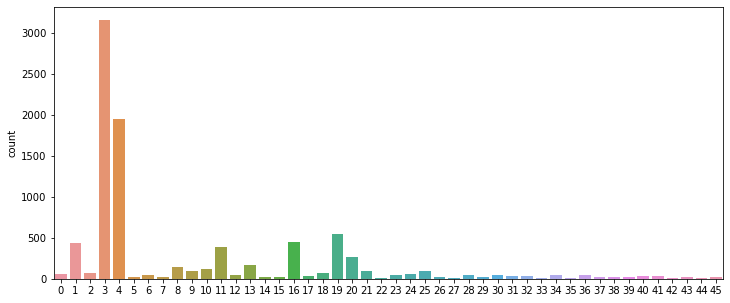

In [36]:
# 클래스 분포 확인

fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)

In [37]:
# 클래스별 갯수 확인

unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


### 2) 원본 뉴스 데이터로 복원

In [38]:
# Vocabulary 생성

word_index = reuters.get_word_index(path="reuters_word_index.json")

# 데이터 매핑 확인

word_index['the']

1

In [39]:
# index_to_word 생성

index_to_word = {index + 3 : word for word, index in word_index.items()}

# 데이터 확인

print(index_to_word[4])

the


In [40]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.

for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [41]:
# 훈련용 뉴스 기사 텍스트 복원
# train data

decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

x_train[:5]

['<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 '<sos> generale de banque sa lt <unk> <unk> and lt heller overseas corp of chicago have each taken 50 pct stakes in <unk> company sa <unk> factors generale de banque said in a statement it gave no financial details of the transaction sa <unk> <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3',
 '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the two fo

In [42]:
# test data

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

x_test[:5]

['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt <unk> <unk> of west germany reuter 3',
 "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration <unk> chairman <unk> <unk> said <unk> told reuters a survey during the curr

### 3) 벡터화 하기

In [43]:
# DTM 생성

dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 4867)


In [44]:
# TF-IDF Matrix 생성

tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 4867)


### 4) 나이브 베이즈 분류기

In [45]:
# 나이브 베이즈 분류기 사용

mod = MultinomialNB()
mod.fit(tfidfv, y_train)

MultinomialNB()

In [46]:
# test data 처리

x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6731967943009796


In [47]:
# 샘플 출력

#원문 출력
print(x_test[3])

#샘플 레이블
print(y_test[3])

<sos> <unk> <unk> oil and gas partnership said it completed the sale of interests in two major oil and gas fields to lt energy assets international corp for 21 mln dlrs the company said it sold about one half of its 50 pct interest in the <unk> hill and north <unk> fields its two largest producing properties it said it used about 20 mln dlrs of the proceeds to <unk> principal on its senior secured notes semi annual principal payments on the remaining 40 mln dlrs of notes have been satisfied until december 1988 as a result it said the company said the note agreements were amended to reflect an easing of some financial <unk> and an increase of interest to 13 5 pct from 13 0 pct until december 1990 it said the <unk> exercise price for 1 125 000 warrants was also reduced to 50 cts from 1 50 dlrs the company said energy assets agreed to share the costs of increasing production at the <unk> hill field reuter 3
4


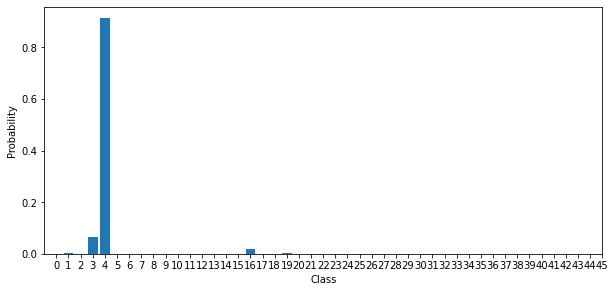

In [48]:
#그래프 시각화
plt.subplot(211)
plt.rcParams["figure.figsize"] = (10,10)
plt.bar(mod.classes_, mod.predict_proba(tfidfv_test[3])[0])
plt.xlim(-1, 21)
plt.xticks(mod.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

In [49]:
# 예측 정답 확인

mod.predict(tfidfv_test[3])

array([4])

### 5) F1-Score, Confusion Matrix

In [50]:
# 평가 score

print(classification_report(y_test, mod.predict(tfidfv_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.50      0.80      0.62       105
           2       0.00      0.00      0.00        20
           3       0.86      0.89      0.87       813
           4       0.59      0.95      0.73       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.28      0.44        25
          10       0.00      0.00      0.00        30
          11       0.48      0.73      0.58        83
          12       0.00      0.00      0.00        13
          13       1.00      0.14      0.24        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.60      0.66      0.62        99
          17       0.00    

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

macro: 단순평균   
weighted: 각 클래스에 속하는 표본의 개수로 가중평균   
accuracy: 정확도. 전체 학습 데이터의 개수에서 클래스를 정확하게 맞춘 개수의 비율.

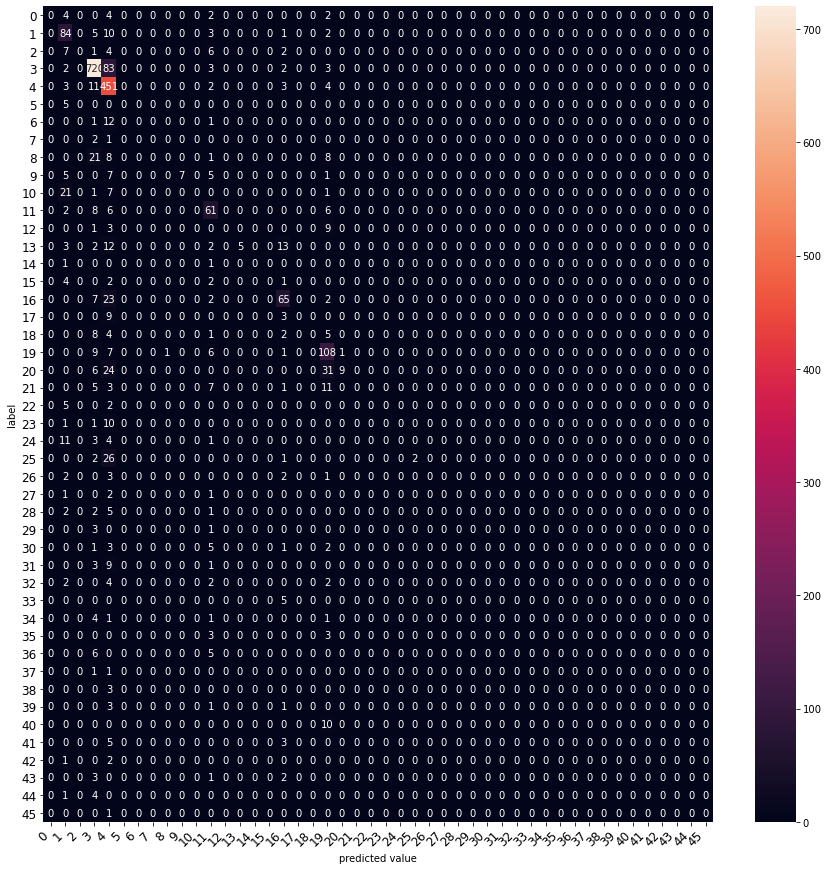

In [51]:
# confusion matrix 시각화

def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
  df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
  fig = plt.figure(figsize=(15,15))
  heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
  plt.ylabel('label')
  plt.xlabel('predicted value')

graph_confusion_matrix(mod, tfidfv_test, y_test)

### 6) 다양한 모델 시도

In [52]:
# Complement Naive Bayes Classifier(CNB)

cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [53]:
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7707034728406055


In [54]:
# Logistic Regression

lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10000)

In [55]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8058771148708815


In [56]:
# LinearSVC

lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1000, dual=False, max_iter=500, penalty='l1')

In [57]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7666963490650045


In [58]:
# Decision Tree

tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [59]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6179875333926982


In [60]:
# Random Forest

forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [61]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.701246660730187


In [62]:
# Gradient Boosting Tree

grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [63]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.767586821015138


In [64]:
# Soft Voting

voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft')

In [65]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8161175422974176


#### 모델별 accuracy

F1-score : 0.67   
Complement Naive Bayes(CNB): 0.7707034728406055  
Logistic Regression : 0.8058771148708815  
LinearSVC : 0.7666963490650045  
Decision Tree : 0.6179875333926982  
Random Forest : 0.701246660730187
Gradient Boosting Tree : 0.767586821015138
Soft Voting : 0.8161175422974176  
    
Soft Voting이 81.61%로 가장 높게 나왔다.

## 3-1 직접 단어 갯수를 설정(7000)

### 1) 데이터 확인하기

In [66]:
#훈련 데이터, 테스트 데이터 로드

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=7000, test_split=0.2)

print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


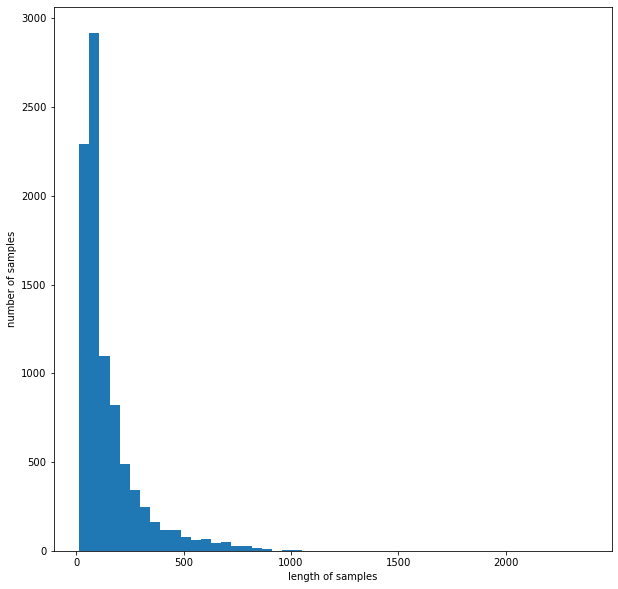

In [67]:
# 데이터 분포 확인

print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

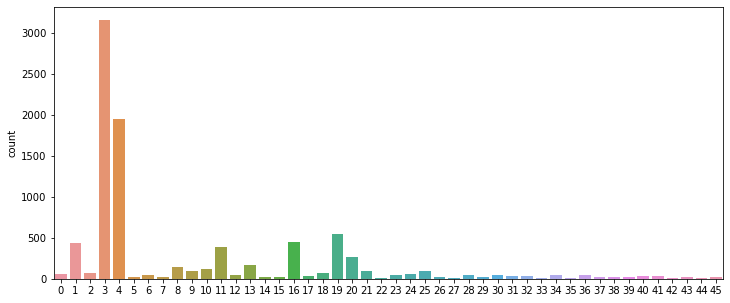

In [68]:
# 클래스 분포 확인

fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)

In [69]:
# 클래스별 갯수 확인

unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


### 2) 원본 뉴스 데이터로 복원

In [70]:
# Vocabulary 생성

word_index = reuters.get_word_index(path="reuters_word_index.json")

# 데이터 매핑 확인

word_index['the']

1

In [71]:
# index_to_word 생성

index_to_word = {index + 3 : word for word, index in word_index.items()}

# 데이터 확인

print(index_to_word[4])

the


In [72]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.

for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [73]:
# 훈련용 뉴스 기사 텍스트 복원
# train data

decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

x_train[:5]

['<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 '<sos> generale de banque sa lt <unk> <unk> and lt heller overseas corp of chicago have each taken 50 pct stakes in <unk> company sa <unk> factors generale de banque said in a statement it gave no financial details of the transaction sa <unk> <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3',
 '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the two fo

In [74]:
# test data

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

x_test[:5]

['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt <unk> <unk> of west germany reuter 3',
 "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration <unk> chairman <unk> yulo said yulo told reuters a survey during the curren

### 3) 벡터화 하기

In [75]:
# DTM 생성

dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 6807)


In [76]:
# TF-IDF Matrix 생성

tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 6807)


### 4) 나이브 베이즈 분류기

In [77]:
# 나이브 베이즈 분류기 사용

mod = MultinomialNB()
mod.fit(tfidfv, y_train)

MultinomialNB()

In [78]:
# test data 처리

x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6647373107747105


In [79]:
# 샘플 출력

#원문 출력
print(x_test[3])

#샘플 레이블
print(y_test[3])

<sos> <unk> <unk> oil and gas partnership said it completed the sale of interests in two major oil and gas fields to lt energy assets international corp for 21 mln dlrs the company said it sold about one half of its 50 pct interest in the oak hill and north <unk> fields its two largest producing properties it said it used about 20 mln dlrs of the proceeds to <unk> principal on its senior secured notes semi annual principal payments on the remaining 40 mln dlrs of notes have been satisfied until december 1988 as a result it said the company said the note agreements were amended to reflect an easing of some financial <unk> and an increase of interest to 13 5 pct from 13 0 pct until december 1990 it said the <unk> exercise price for 1 125 000 warrants was also reduced to 50 cts from 1 50 dlrs the company said energy assets agreed to share the costs of increasing production at the oak hill field reuter 3
4


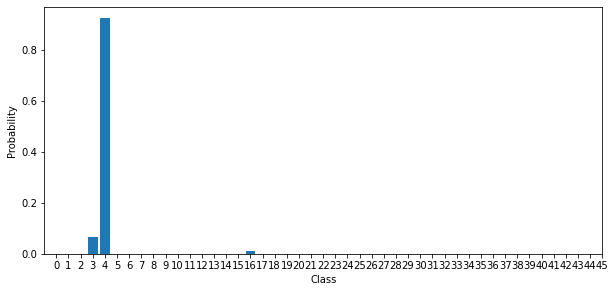

In [80]:
#그래프 시각화
plt.subplot(211)
plt.rcParams["figure.figsize"] = (10,10)
plt.bar(mod.classes_, mod.predict_proba(tfidfv_test[3])[0])
plt.xlim(-1, 21)
plt.xticks(mod.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

In [81]:
# 예측 정답 확인

mod.predict(tfidfv_test[3])

array([4])

### 5) F1-Score, Confusion Matrix

In [82]:
# 평가 score

print(classification_report(y_test, mod.predict(tfidfv_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.56      0.76      0.65       105
           2       0.00      0.00      0.00        20
           3       0.84      0.89      0.86       813
           4       0.55      0.95      0.70       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.16      0.28        25
          10       0.00      0.00      0.00        30
          11       0.53      0.69      0.60        83
          12       0.00      0.00      0.00        13
          13       1.00      0.05      0.10        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.64      0.62      0.63        99
          17       0.00    

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

macro: 단순평균   
weighted: 각 클래스에 속하는 표본의 개수로 가중평균   
accuracy: 정확도. 전체 학습 데이터의 개수에서 클래스를 정확하게 맞춘 개수의 비율.

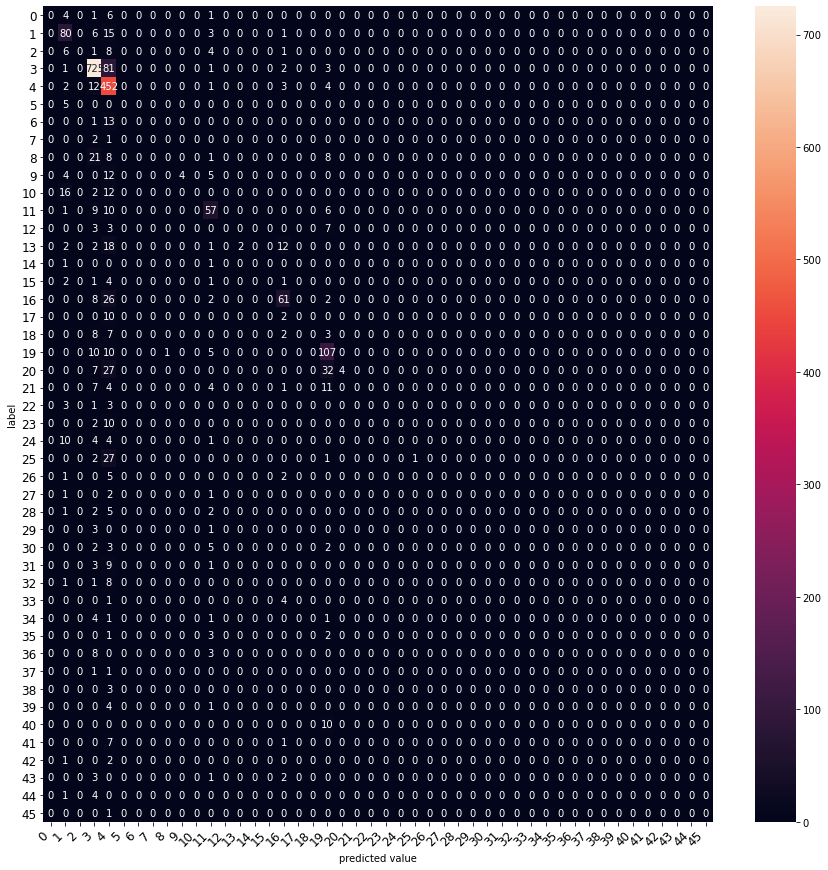

In [83]:
# confusion matrix 시각화

def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
  df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
  fig = plt.figure(figsize=(15,15))
  heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
  plt.ylabel('label')
  plt.xlabel('predicted value')

graph_confusion_matrix(mod, tfidfv_test, y_test)

### 6) 다양한 모델 시도

In [84]:
# Complement Naive Bayes Classifier(CNB)

cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [85]:
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7684772929652716


In [86]:
# Logistic Regression

lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10000)

In [87]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.807212822796082


In [88]:
# LinearSVC

lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1000, dual=False, max_iter=500, penalty='l1')

In [89]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7684772929652716


In [90]:
# Decision Tree

tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [91]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6206589492430988


In [92]:
# Random Forest

forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [93]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6736420302760463


In [94]:
# Gradient Boosting Tree

grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [95]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7604630454140695


In [96]:
# Soft Voting

voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft')

In [97]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.815227070347284


#### 모델별 accuracy

F1-score : 0.66   
Complement Naive Bayes(CNB): 0.7684772929652716  
Logistic Regression : 0.807212822796082  
LinearSVC : 0.7684772929652716  
Decision Tree : 0.6206589492430988  
Random Forest : 0.6736420302760463
Gradient Boosting Tree : 0.7604630454140695
Soft Voting : 0.815227070347284  
    
Soft Voting이 81.52%로 가장 높게 나왔다.

## 3-2 직접 단어 갯수를 설정(3000)

### 1) 데이터 확인하기

In [2]:
#훈련 데이터, 테스트 데이터 로드

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=3000, test_split=0.2)

print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


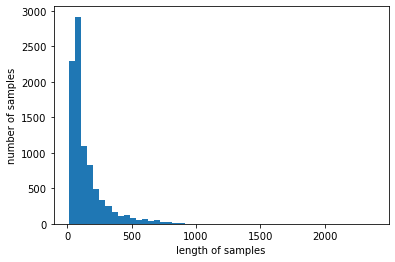

In [3]:
# 데이터 분포 확인

print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

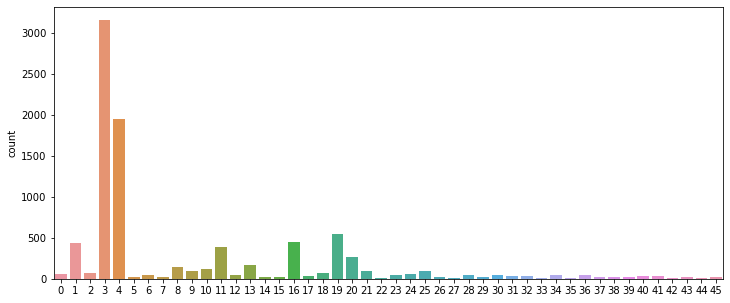

In [4]:
# 클래스 분포 확인

fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)

In [5]:
# 클래스별 갯수 확인

unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


### 2) 원본 뉴스 데이터로 복원

In [6]:
# Vocabulary 생성

word_index = reuters.get_word_index(path="reuters_word_index.json")

# 데이터 매핑 확인

word_index['the']

1

In [7]:
# index_to_word 생성

index_to_word = {index + 3 : word for word, index in word_index.items()}

# 데이터 확인

print(index_to_word[4])

the


In [8]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.

for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [9]:
# 훈련용 뉴스 기사 텍스트 복원
# train data

decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

x_train[:5]

['<sos> <unk> <unk> said as a result of its december acquisition of <unk> co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and <unk> operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 '<sos> <unk> de <unk> sa lt <unk> <unk> and lt <unk> overseas corp of chicago have each taken 50 pct <unk> in <unk> company sa <unk> factors <unk> de <unk> said in a statement it gave no financial details of the transaction sa <unk> <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3',
 '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 <unk> 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the two for one spl

In [10]:
# test data

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

x_test[:5]

['<sos> the great atlantic and pacific <unk> co said its three year <unk> mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations <unk> 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt <unk> <unk> of west germany reuter 3',
 "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration <unk> chairman <unk> <unk> said <unk> told reuters a survey during the c

### 3) 벡터화 하기

In [11]:
# DTM 생성

dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 2919)


In [12]:
# TF-IDF Matrix 생성

tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 2919)


### 4) 나이브 베이즈 분류기

In [13]:
# 나이브 베이즈 분류기 사용

mod = MultinomialNB()
mod.fit(tfidfv, y_train)

MultinomialNB()

In [14]:
# test data 처리

x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6874443455031166


In [15]:
# 샘플 출력

#원문 출력
print(x_test[3])

#샘플 레이블
print(y_test[3])

<sos> <unk> <unk> oil and gas partnership said it completed the sale of interests in two major oil and gas fields to lt energy assets international corp for 21 mln dlrs the company said it sold about one half of its 50 pct interest in the <unk> <unk> and north <unk> fields its two largest producing properties it said it used about 20 mln dlrs of the proceeds to <unk> principal on its senior <unk> notes semi annual principal payments on the remaining 40 mln dlrs of notes have been satisfied until december 1988 as a result it said the company said the note agreements were <unk> to reflect an easing of some financial <unk> and an increase of interest to 13 5 pct from 13 0 pct until december 1990 it said the <unk> exercise price for 1 125 000 warrants was also reduced to 50 cts from 1 50 dlrs the company said energy assets agreed to share the costs of increasing production at the <unk> <unk> field reuter 3
4


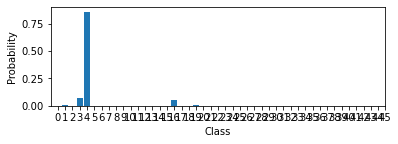

In [16]:
#그래프 시각화
plt.subplot(211)
plt.rcParams["figure.figsize"] = (10,10)
plt.bar(mod.classes_, mod.predict_proba(tfidfv_test[3])[0])
plt.xlim(-1, 21)
plt.xticks(mod.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

In [17]:
# 예측 정답 확인

mod.predict(tfidfv_test[3])

array([4])

### 5) F1-Score, Confusion Matrix

In [18]:
# 평가 score

print(classification_report(y_test, mod.predict(tfidfv_test)))

              precision    recall  f1-score   support

           0       1.00      0.25      0.40        12
           1       0.49      0.82      0.61       105
           2       0.00      0.00      0.00        20
           3       0.88      0.88      0.88       813
           4       0.64      0.95      0.76       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.48      0.65        25
          10       1.00      0.10      0.18        30
          11       0.45      0.76      0.56        83
          12       0.00      0.00      0.00        13
          13       0.70      0.19      0.30        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.56      0.76      0.64        99
          17       0.00    

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

macro: 단순평균   
weighted: 각 클래스에 속하는 표본의 개수로 가중평균   
accuracy: 정확도. 전체 학습 데이터의 개수에서 클래스를 정확하게 맞춘 개수의 비율.

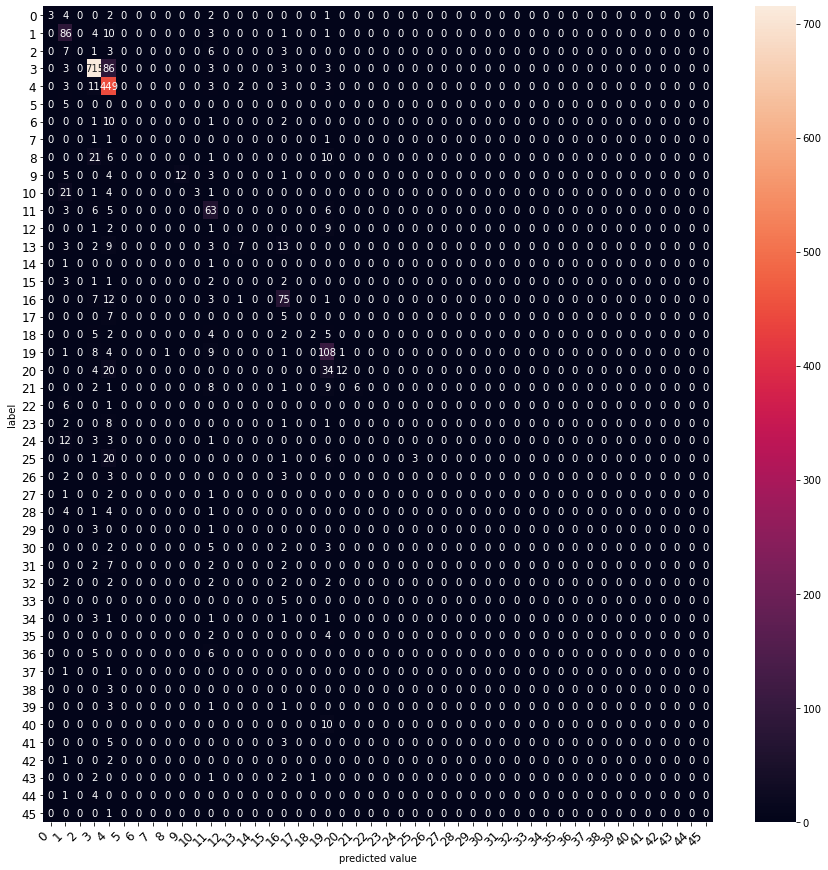

In [19]:
# confusion matrix 시각화

def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
  df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
  fig = plt.figure(figsize=(15,15))
  heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
  plt.ylabel('label')
  plt.xlabel('predicted value')

graph_confusion_matrix(mod, tfidfv_test, y_test)

### 6) 다양한 모델 시도

In [20]:
# Complement Naive Bayes Classifier(CNB)

cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [21]:
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7644701691896705


In [22]:
# Logistic Regression

lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10000)

In [23]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.794746215494212


In [24]:
# LinearSVC

lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1000, dual=False, max_iter=500, penalty='l1')

In [25]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7502226179875334


In [26]:
# Decision Tree

tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [27]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6260017809439002


In [28]:
# Random Forest

forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [29]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6856634016028496


In [30]:
# Gradient Boosting Tree

grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [31]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7756010685663401


In [32]:
# Soft Voting

voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft')

In [33]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8103294746215495


#### 모델별 accuracy

F1-score : 0.69   
Complement Naive Bayes(CNB): 0.7644701691896705  
Logistic Regression : 0.794746215494212  
LinearSVC : 0.7502226179875334  
Decision Tree : 0.6260017809439002  
Random Forest : 0.6856634016028496
Gradient Boosting Tree : 0.7756010685663401
Soft Voting : 0.8103294746215495  
    
Soft Voting이 81.03%로 가장 높게 나왔다.

## 3-3 직접 단어 갯수를 설정(1500)

### 1) 데이터 확인하기

In [34]:
#훈련 데이터, 테스트 데이터 로드

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=1500, test_split=0.2)

print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


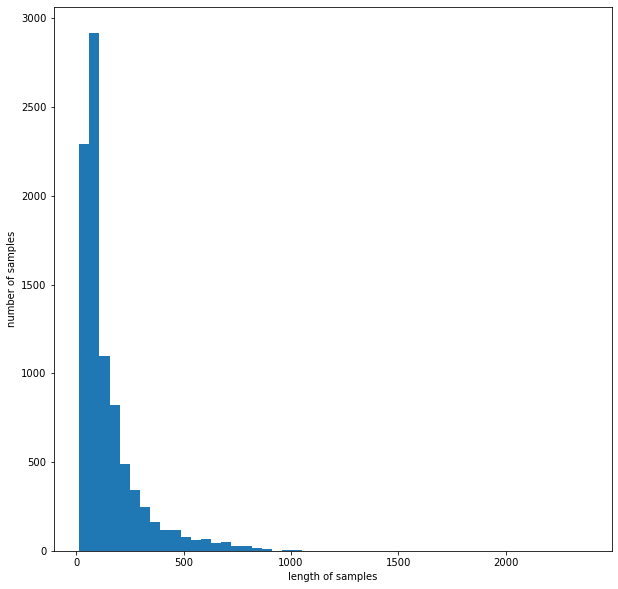

In [35]:
# 데이터 분포 확인

print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

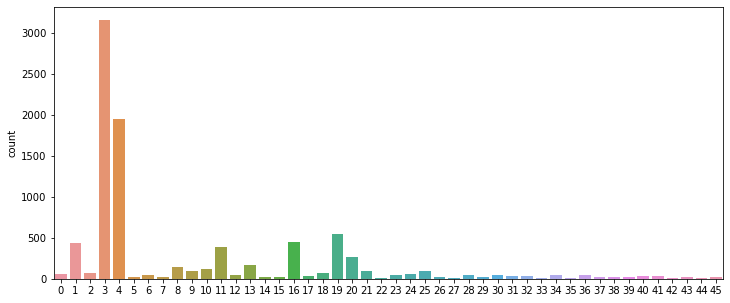

In [36]:
# 클래스 분포 확인

fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)

In [37]:
# 클래스별 갯수 확인

unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


### 2) 원본 뉴스 데이터로 복원

In [38]:
# Vocabulary 생성

word_index = reuters.get_word_index(path="reuters_word_index.json")

# 데이터 매핑 확인

word_index['the']

1

In [39]:
# index_to_word 생성

index_to_word = {index + 3 : word for word, index in word_index.items()}

# 데이터 확인

print(index_to_word[4])

the


In [40]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.

for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [41]:
# 훈련용 뉴스 기사 텍스트 복원
# train data

decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

x_train[:5]

['<sos> <unk> <unk> said as a result of its december acquisition of <unk> co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and <unk> operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 '<sos> <unk> de <unk> <unk> lt <unk> <unk> and lt <unk> overseas corp of chicago have each taken 50 pct <unk> in <unk> company <unk> <unk> factors <unk> de <unk> said in a statement it gave no financial details of the transaction <unk> <unk> <unk> turnover in 1986 was 17 5 billion <unk> francs reuter 3',
 '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 <unk> 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the two for 

In [42]:
# test data

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

x_test[:5]

['<sos> the great <unk> and pacific <unk> co said its three year <unk> mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us <unk> better than expected results in the fourth quarter ended february 28 its net income from continuing operations <unk> 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the <unk> capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt <unk> <unk> of west germany reuter 3',
 "<sos> <unk> sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration <unk> chairman <unk> <unk> said <unk> told reuters a <unk> during the current <unk> s

### 3) 벡터화 하기

In [43]:
# DTM 생성

dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 1455)


In [44]:
# TF-IDF Matrix 생성

tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 1455)


### 4) 나이브 베이즈 분류기

In [45]:
# 나이브 베이즈 분류기 사용

mod = MultinomialNB()
mod.fit(tfidfv, y_train)

MultinomialNB()

In [46]:
# test data 처리

x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6914514692787177


In [47]:
# 샘플 출력

#원문 출력
print(x_test[3])

#샘플 레이블
print(y_test[3])

<sos> <unk> <unk> oil and gas partnership said it completed the sale of interests in two major oil and gas fields to lt energy assets international corp for 21 mln dlrs the company said it sold about one half of its 50 pct interest in the <unk> <unk> and north <unk> fields its two largest producing properties it said it used about 20 mln dlrs of the proceeds to <unk> <unk> on its senior <unk> notes <unk> annual <unk> payments on the remaining 40 mln dlrs of notes have been <unk> until december 1988 as a result it said the company said the note agreements were <unk> to reflect an <unk> of some financial <unk> and an increase of interest to 13 5 pct from 13 0 pct until december <unk> it said the <unk> <unk> price for 1 125 000 warrants was also reduced to 50 cts from 1 50 dlrs the company said energy assets agreed to share the costs of increasing production at the <unk> <unk> field reuter 3
4


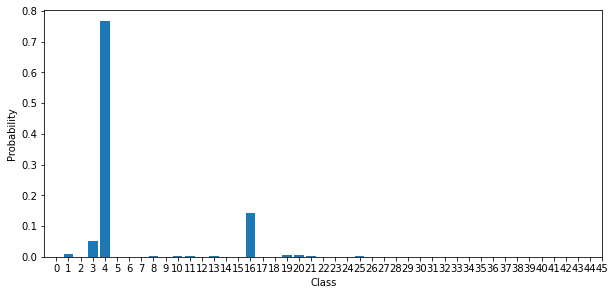

In [48]:
#그래프 시각화
plt.subplot(211)
plt.rcParams["figure.figsize"] = (10,10)
plt.bar(mod.classes_, mod.predict_proba(tfidfv_test[3])[0])
plt.xlim(-1, 21)
plt.xticks(mod.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

In [49]:
# 예측 정답 확인

mod.predict(tfidfv_test[3])

array([4])

### 5) F1-Score, Confusion Matrix

In [50]:
# 평가 score

print(classification_report(y_test, mod.predict(tfidfv_test)))

              precision    recall  f1-score   support

           0       1.00      0.25      0.40        12
           1       0.47      0.78      0.59       105
           2       0.00      0.00      0.00        20
           3       0.91      0.86      0.88       813
           4       0.63      0.94      0.75       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.62      0.21      0.31        38
           9       0.92      0.44      0.59        25
          10       1.00      0.10      0.18        30
          11       0.44      0.83      0.58        83
          12       0.00      0.00      0.00        13
          13       0.80      0.11      0.19        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.50      0.75      0.60        99
          17       0.00    

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

macro: 단순평균   
weighted: 각 클래스에 속하는 표본의 개수로 가중평균   
accuracy: 정확도. 전체 학습 데이터의 개수에서 클래스를 정확하게 맞춘 개수의 비율.

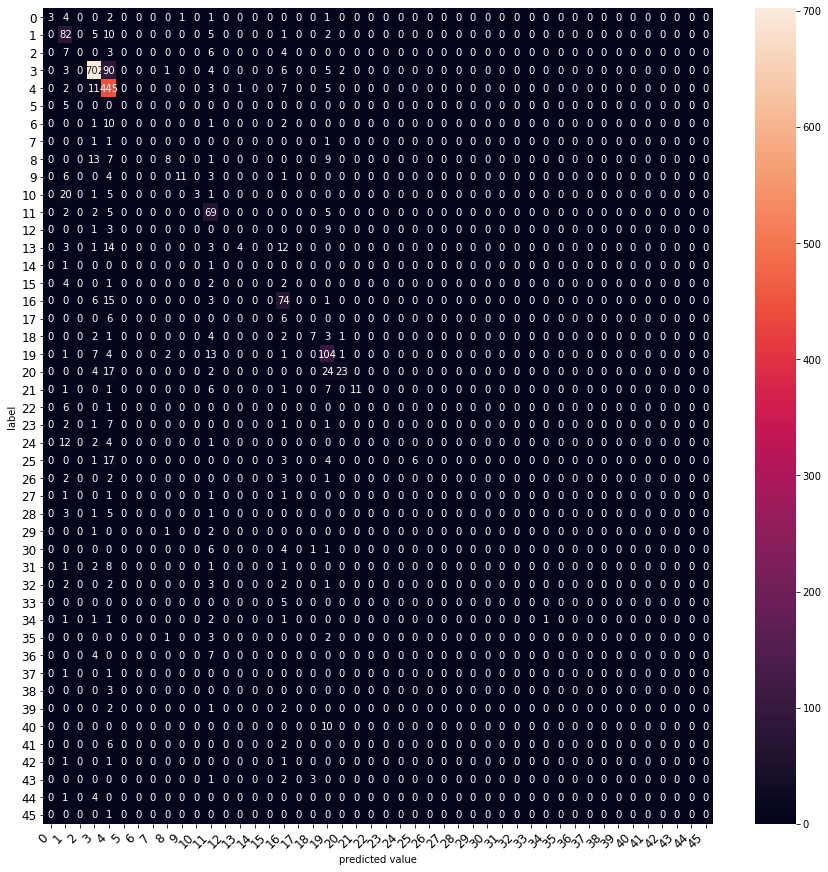

In [51]:
# confusion matrix 시각화

def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
  df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
  fig = plt.figure(figsize=(15,15))
  heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
  plt.ylabel('label')
  plt.xlabel('predicted value')

graph_confusion_matrix(mod, tfidfv_test, y_test)

### 6) 다양한 모델 시도

In [52]:
# Complement Naive Bayes Classifier(CNB)

cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [53]:
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.748886910062333


In [54]:
# Logistic Regression

lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10000)

In [55]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7747105966162066


In [56]:
# LinearSVC

lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1000, dual=False, max_iter=500, penalty='l1')

In [57]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.715939447907391


In [58]:
# Decision Tree

tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [59]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6130899376669635


In [60]:
# Random Forest

forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [61]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7025823686553874


In [62]:
# Gradient Boosting Tree

grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [63]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7577916295636687


In [64]:
# Soft Voting

voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft')

In [65]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7867319679430098


#### 모델별 accuracy

F1-score : 0.69   
Complement Naive Bayes(CNB): 0.748886910062333  
Logistic Regression : 0.7747105966162066  
LinearSVC : 0.715939447907391  
Decision Tree : 0.6130899376669635  
Random Forest : 0.7025823686553874   
Gradient Boosting Tree : 0.7577916295636687   
Soft Voting : 0.7867319679430098   
    
Soft Voting이 78.67%로 가장 높게 나왔다.

## 최적 솔루션
모든 단어를 사용한 Soft Voting이 81.88로 가장 높게 나왔다

## 4. 딥러닝 모델과 비교

In [83]:
# # 학습 데이터 처리

# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import to_categorical
# (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

# max_len = 100
# x_train = pad_sequences(x_train, maxlen=max_len) # 훈련용 뉴스 기사 패딩
# x_test = pad_sequences(x_test, maxlen=max_len) # 테스트용 뉴스 기사 패딩

# # 원 핫 인코딩

# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test) 

In [85]:
#데이터 처리
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

word_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = {index + 3 : word for word, index in word_index.items()}

for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

# 벡터화
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)

tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)




In [86]:
#  RNN 사용
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding

model = keras.Sequential()
model.add(Embedding(1000, 120))
model.add(keras.layers.LSTM(120))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(46, activation='softmax'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.fit(tfidfv, y_train)
model.summary()

InvalidArgumentError: indices[1] = [0,25158] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse]

구현 실패

# 회고

머신러닝은 잘 비교 되었으나 딥러닝 구현은 실패하였다.
공부가 정말 많이 부족함을 느꼈다.